In [1]:
%load_ext heat

---------------------------------------------------------- START
device is cuda:0
---------------------------------------------------------- START:1
---------------------------------------------------------- START:2
---------------------------------------------------------- START:3
---------------------------------------------------------- START:4
---------------------------------------------------------- START:5
---------------------------------------------------------- START:6
---------------------------------------------------------- START:7
---------------------------------------------------------- START:8 enbd STARET
---------------------- STARTED class Learner
---------------------- PASSED LEARNER
---------------------- STARTED torch_base.py
*********################### ######################## patch_tb
---------------------- PASSED torch_base.py
---------------------------------------------------------- ALMOOOOST END
---------------------------------------------------------- Bef

epoch,train_loss,valid_loss,accuracy,time
0,2.474669,2.307532,0.128571,00:10


Learner#fit@epoch... train... 0
Learner#_do_epoch_train internal try
Learner#all_batches@n_iter = 70
Learner#one_batch 0 b is the batch
Learner#fit@epoc validate 0
Learner#_do_epoch_validate@internal try
Learner#all_batches@n_iter = 70
Learner#one_batch 0 b is the batch
Learner#fit@end cleanup
---------------------------------------------------------- After fit


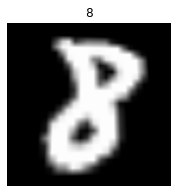

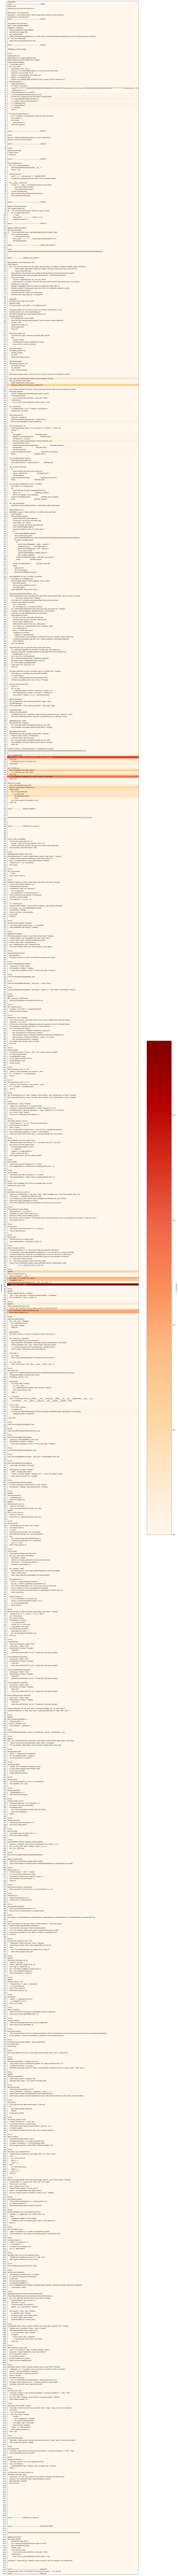

In [2]:
%%heat
import pdb
print("---------------------------------------------------------- START")
import torch
#import torch_xla.core.xla_model as xm

#tpu_device = xm.xla_device()
tpu_device = torch.device('cuda:0') #torch.cuda.device("cuda:0")#.current_device()
print(f"device is {tpu_device}")
print("---------------------------------------------------------- START:1")

from fastai2.vision.all import *
path = untar_data(URLs.MNIST)
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSubsetSplitter(train_sz=0.001,valid_sz=0.001),#GrandparentSplitter(train_name='training',valid_name='testing'),
#    item_tfms=Resize(28),
    batch_tfms=aug_transforms(size=224)
)
print("---------------------------------------------------------- START:2")

#datablock.summary(path)

# %%
printed_device=0
NUM_PIXELS=3 # 1 single channedl 3 rgb
NUM_OUTPUTS=10 #2 for MNIST_TINY 10 MNIST
class Lenet2(nn.Module):
    """Lenet with layers"""
    def __init__(self):
        super(Lenet2, self).__init__()
        self.conv1 = nn.Conv2d(NUM_PIXELS, 6, 3) # set 3 for first item if RGB
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(46656, 120) #(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, NUM_OUTPUTS) # Only 2 outputs (3 and 7) instead of 10
    def forward(self, x):
        global printed_device
        if x.device != tpu_device:
          print(f"************** ######################### EL DEVICE ES {tpu_device} no es {x.device} ######################### **************") if printed_device < 10 else noop
          printed_device += 1
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


print("---------------------------------------------------------- START:3")

# %%
dls_tpu = datablock.dataloaders(path,bs=1, device=tpu_device)
dls_tpu.vocab, dls_tpu.show_batch()

print("---------------------------------------------------------- START:4")

# %%
def print_local(msg):
  if False: return
  print(msg)

print("---------------------------------------------------------- START:5")

class XLAOptimProxy:
    def __init__(self,opt:Optimizer):
        print("XLAOptimProxy#inicializando __init__")
        self.opt = opt

    def xla_step(self):
        print("------------- xla optimizer!!!!!!!! BARRIER TRYE")
        xm.optimizer_step(self.opt,barrier=True) # sync on gradient update

    def __getattr__(self,name):
        if name == '___step___': # override proxying for step method
                print_local("calling xla_step")
                return getattr(self,'xla_step')
        # proxy everything else
        #print_local(f"calling XLAOptimProxy#{name}")
        return getattr(self.opt,name)


print("---------------------------------------------------------- START:6")

@patch_to(ParamScheduler)
def _update_val(self, pct):
#        for n,f in self.scheds.items(): self.opt.set_hyper(n, f(pct))
        for n,f in self.scheds.items():
            v = f(pct)
            print_local(f"---------------------- A f(pct) = {v}")
            self.opt.set_hyper(n, v)

print("---------------------------------------------------------- START:7")

@patch_to(ParamScheduler)
def after_batch(self):
#        for p in self.scheds.keys(): self.hps[p].append(self.opt.hypers[-1][p])
        for p in self.scheds.keys():
            v = self.opt.hypers[-1][p]
            print_local(f"---------------------- B after_batch ParamScheduler {v}")
            self.hps[p].append(v)

print("---------------------------------------------------------- START:8 enbd STARET")

# %%
####################################################################################333


print("---------------------- STARTED class Learner")

@log_args(but='dls,model,opt_func,cbs')
class Learner():
    def __init__(self, dls, model, loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=trainable_params, cbs=None,
                 metrics=None, path=None, model_dir='models', wd=None, wd_bn_bias=False, train_bn=True,
                 moms=(0.95,0.85,0.95)):
        store_attr(self, "dls,model,opt_func,lr,splitter,model_dir,wd,wd_bn_bias,train_bn,metrics,moms")
        self.training,self.create_mbar,self.logger,self.opt,self.cbs = False,True,print,None,L()
        if loss_func is None:
            loss_func = getattr(dls.train_ds, 'loss_func', None)
            assert loss_func is not None, "Could not infer loss function from the data, please pass a loss function."
        self.loss_func = loss_func
        self.path = Path(path) if path is not None else getattr(dls, 'path', Path('.'))
        self.add_cbs([(cb() if isinstance(cb, type) else cb) for cb in L(defaults.callbacks)+L(cbs)])
        self.model.to(self.dls.device)
        if hasattr(self.model, 'reset'): self.model.reset()
        self.epoch,self.n_epoch,self.loss = 0,1,tensor(0.)

    @property
    def metrics(self): return self._metrics
    @metrics.setter
    def metrics(self,v): self._metrics = L(v).map(mk_metric)

    def _grab_cbs(self, cb_cls): return L(cb for cb in self.cbs if isinstance(cb, cb_cls))
    def add_cbs(self, cbs): L(cbs).map(self.add_cb)
    def remove_cbs(self, cbs): L(cbs).map(self.remove_cb)
    def add_cb(self, cb):
        old = getattr(self, cb.name, None)
        assert not old or isinstance(old, type(cb)), f"self.{cb.name} already registered"
        cb.learn = self
        setattr(self, cb.name, cb)
        self.cbs.append(cb)
        return self

    def remove_cb(self, cb):
        if isinstance(cb, type): self.remove_cbs(self._grab_cbs(cb))
        else:
            cb.learn = None
            if hasattr(self, cb.name): delattr(self, cb.name)
            if cb in self.cbs: self.cbs.remove(cb)

    @contextmanager
    def added_cbs(self, cbs):
        self.add_cbs(cbs)
        try: yield
        finally: self.remove_cbs(cbs)

    @contextmanager
    def removed_cbs(self, cbs):
        self.remove_cbs(cbs)
        try: yield self
        finally: self.add_cbs(cbs)

    def ordered_cbs(self, event): return [cb for cb in sort_by_run(self.cbs) if hasattr(cb, event)]

    def __call__(self, event_name): L(event_name).map(self._call_one)
    def _call_one(self, event_name):
        assert hasattr(event, event_name)
        [cb(event_name) for cb in sort_by_run(self.cbs)]

    def _bn_bias_state(self, with_bias): return bn_bias_params(self.model, with_bias).map(self.opt.state)
    def create_opt(self):
        self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
        if not self.wd_bn_bias:
            for p in self._bn_bias_state(True ): p['do_wd'] = False
        if self.train_bn:
            for p in self._bn_bias_state(False): p['force_train'] = True

    def _split(self, b):
        i = getattr(self.dls, 'n_inp', 1 if len(b)==1 else len(b)-1)
        self.xb,self.yb = b[:i],b[i:]

    def all_batches(self):
        self.n_iter = len(self.dl)
        print(f"Learner#all_batches@n_iter = {self.n_iter}")
        for o in enumerate(self.dl): self.one_batch(*o)

    def one_batch(self, i, b):
        print(f"Learner#one_batch {i} b is the batch") if i % 10000 == 0 else noop
        self.iter = i
        try:
            self._split(b);                                  self('begin_batch')
            self.pred = self.model(*self.xb);                self('after_pred')
            if len(self.yb) == 0: return
            self.loss = self.loss_func(self.pred, *self.yb); self('after_loss')
            if not self.training: return
            self.loss.backward(retain_graph=True);                            self('after_backward')
            self.opt.step();                                 self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:                         self('after_cancel_batch')
        finally:                                             self('after_batch')

    def _do_begin_fit(self, n_epoch):
        print("Learner#_do_begin_fit")
        self.n_epoch,self.loss = n_epoch,tensor(0.);         self('begin_fit')

    def _do_epoch_train(self):
        try:
            print("Learner#_do_epoch_train internal try")
            self.dl = self.dls.train;                        self('begin_train')
            self.all_batches()
        except CancelTrainException:                         self('after_cancel_train')
        finally:                                             self('after_train')

    def _do_epoch_validate(self, ds_idx=1, dl=None):
        if dl is None: dl = self.dls[ds_idx]
        try:
            print("Learner#_do_epoch_validate@internal try")
            self.dl = dl;                                    self('begin_validate')
            with torch.no_grad(): self.all_batches()
        except CancelValidException:                         self('after_cancel_validate')
        finally:                                             self('after_validate')

    def _end_cleanup(self):
        self.dl,self.xb,self.yb,self.pred,self.loss = None,(None,),(None,),None,None

    @log_args(but='cbs')
    def fit(self, n_epoch, lr=None, wd=None, cbs=None, reset_opt=False):
        print("fit starts")
        with self.added_cbs(cbs):
            print("fit starts with added callbacks")
            if reset_opt or not self.opt: self.create_opt()
            if wd is None: wd = self.wd
            if wd is not None: self.opt.set_hypers(wd=wd)
            print("Learner#fit@set hypers")
            self.opt.set_hypers(lr=self.lr if lr is None else lr)
            try:
                print("Learner#fit@do begin fit")
                self._do_begin_fit(n_epoch)
                print("Learner#fit@FOR each epoch LOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOP")
                for epoch in range(n_epoch):
                    try:
                        print(f"Learner#fit@epoch... begin... {epoch}")
                        self.epoch=epoch;          self('begin_epoch')
                        print(f"Learner#fit@epoch... train... {epoch}")
                        self._do_epoch_train()
                        print(f"Learner#fit@epoc validate {epoch}")
                        self._do_epoch_validate()
                    except CancelEpochException:   self('after_cancel_epoch')
                    finally:                       self('after_epoch')

            except CancelFitException:             self('after_cancel_fit')
            finally:
                self('after_fit')
                self._end_cleanup()
                print("Learner#fit@end cleanup")

    def validate(self, ds_idx=1, dl=None, cbs=None):
        if dl is None: dl = self.dls[ds_idx]
        with self.added_cbs(cbs), self.no_logging(), self.no_mbar():
            self(_before_epoch)
            self._do_epoch_validate(ds_idx, dl)
            self(_after_epoch)
        return getattr(self, 'final_record', None)

    @delegates(GatherPredsCallback.__init__)
    def get_preds(self, ds_idx=1, dl=None, with_input=False, with_decoded=False, with_loss=False, act=None,
                  inner=False, reorder=True, **kwargs):
        if dl is None: dl = self.dls[ds_idx].new(shuffled=False, drop_last=False)
        if reorder and hasattr(dl, 'get_idxs'):
            idxs = dl.get_idxs()
            dl = dl.new(get_idxs = _ConstantFunc(idxs))
        cb = GatherPredsCallback(with_input=with_input, with_loss=with_loss, **kwargs)
        ctx_mgrs = [self.no_logging(), self.added_cbs(cb), self.no_mbar()]
        if with_loss: ctx_mgrs.append(self.loss_not_reduced())
        with ExitStack() as stack:
            for mgr in ctx_mgrs: stack.enter_context(mgr)
            self(event.begin_epoch if inner else _before_epoch)
            self._do_epoch_validate(dl=dl)
            self(event.after_epoch if inner else _after_epoch)
            if act is None: act = getattr(self.loss_func, 'activation', noop)
            res = cb.all_tensors()
            pred_i = 1 if with_input else 0
            if res[pred_i] is not None:
                res[pred_i] = act(res[pred_i])
                if with_decoded: res.insert(pred_i+2, getattr(self.loss_func, 'decodes', noop)(res[pred_i]))
            if reorder and hasattr(dl, 'get_idxs'): res = nested_reorder(res, tensor(idxs).argsort())
            return tuple(res)
        self._end_cleanup()

    def predict(self, item, rm_type_tfms=None, with_input=False):
        dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
        inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
        i = getattr(self.dls, 'n_inp', -1)
        inp = (inp,) if i==1 else tuplify(inp)
        dec = self.dls.decode_batch(inp + tuplify(dec_preds))[0]
        dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
        res = dec_targ,dec_preds[0],preds[0]
        if with_input: res = (dec_inp,) + res
        return res

    def show_results(self, ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs):
        if dl is None: dl = self.dls[ds_idx].new(shuffle=shuffle)
        b = dl.one_batch()
        _,_,preds = self.get_preds(dl=[b], with_decoded=True)
        self.dls.show_results(b, preds, max_n=max_n, **kwargs)

    def show_training_loop(self):
        indent = 0
        for s in _loop:
            if s.startswith('Start'): print(f'{" "*indent}{s}'); indent += 2
            elif s.startswith('End'): indent -= 2; print(f'{" "*indent}{s}')
            else: print(f'{" "*indent} - {s:15}:', self.ordered_cbs(s))

    @contextmanager
    def no_logging(self): return replacing_yield(self, 'logger', noop)
    @contextmanager
    def no_mbar(self):    return replacing_yield(self, 'create_mbar', False)

    @contextmanager
    def loss_not_reduced(self):
        if hasattr(self.loss_func, 'reduction'): return replacing_yield(self.loss_func, 'reduction', 'none')
        else: return replacing_yield(self, 'loss_func', partial(self.loss_func, reduction='none'))

    @delegates(save_model)
    def save(self, file, **kwargs):
        file = join_path_file(file, self.path/self.model_dir, ext='.pth')
        save_model(file, self.model, getattr(self,'opt',None), **kwargs)

    @delegates(load_model)
    def load(self, file, with_opt=None, device=None, **kwargs):
        if device is None: device = self.dls.device
        if self.opt is None: self.create_opt()
        file = join_path_file(file, self.path/self.model_dir, ext='.pth')
        load_model(file, self.model, self.opt, device=device, **kwargs)
        return self

Learner.x,Learner.y = add_props(lambda i,x: detuplify((x.xb,x.yb)[i]))
###################################################################33333

def _is_instance(f, gs):
    tst = [g if type(g) in [type, 'function'] else g.__class__ for g in gs]
    for g in tst:
        if isinstance(f, g) or f==g: return True
    return False

def _is_first(f, gs):
    for o in L(getattr(f, 'run_after', None)):
        if _is_instance(o, gs): return False
    for g in gs:
        if _is_instance(f, L(getattr(g, 'run_before', None))): return False
    return True

def sort_by_run(fs):
    end = L(fs).attrgot('toward_end')
    inp,res = L(fs)[~end] + L(fs)[end], L()
    while len(inp):
        for i,o in enumerate(inp):
            if _is_first(o, inp):
                res.append(inp.pop(i))
                break
        else: raise Exception("Impossible to sort")
    return res


print("---------------------- PASSED LEARNER")



##################################################################33 torch_base.py



print("---------------------- STARTED torch_base.py")





if torch.cuda.is_available():
    if torch.cuda.current_device()==0:
        def_gpu = int(os.environ.get('DEFAULT_GPU') or 0)
        if torch.cuda.device_count()>=def_gpu: torch.cuda.set_device(def_gpu)
    torch.backends.cudnn.benchmark = True

# Cell
@delegates(plt.subplots, keep=True)
def subplots(nrows=1, ncols=1, figsize=None, imsize=3, add_vert=0, **kwargs):
    if figsize is None: figsize=(ncols*imsize, nrows*imsize+add_vert)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if nrows*ncols==1: ax = array([ax])
    return fig,ax

# Cell
def _fig_bounds(x):
    r = x//32
    return min(5, max(1,r))

# Cell
def show_image(im, ax=None, figsize=None, title=None, ctx=None, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    # Handle pytorch axis order
    if hasattrs(im, ('data','cpu','permute')):
        im = im.data.cpu()
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=array(im)
    # Handle 1-channel images
    if im.shape[-1]==1: im=im[...,0]

    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (_fig_bounds(im.shape[0]), _fig_bounds(im.shape[1]))
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

# Cell
def show_titled_image(o, **kwargs):
    "Call `show_image` destructuring `o` to `(img,title)`"
    show_image(o[0], title=str(o[1]), **kwargs)

# Cell
@delegates(subplots)
def show_images(ims, nrows=1, ncols=None, titles=None, **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    if ncols is None: ncols = int(math.ceil(len(ims)/nrows))
    if titles is None: titles = [None]*len(ims)
    axs = subplots(nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip(ims, titles, axs): show_image(im, ax=ax, title=t)

# Cell
class ArrayBase(ndarray):
    @classmethod
    def _before_cast(cls, x): return x if isinstance(x,ndarray) else array(x)

# Cell
class ArrayImageBase(ArrayBase):
    _show_args = {'cmap':'viridis'}
    def show(self, ctx=None, **kwargs):
        return show_image(self, ctx=ctx, **{**self._show_args, **kwargs})

# Cell
class ArrayImage(ArrayImageBase): pass

# Cell
class ArrayImageBW(ArrayImage): _show_args = {'cmap':'Greys'}

# Cell
class ArrayMask(ArrayImageBase): _show_args = {'alpha':0.5, 'cmap':'tab20', 'interpolation':'nearest'}

# Cell
@patch
def __array_eq__(self:Tensor,b):
    return torch.equal(self,b) if self.dim() else self==b

# Cell
def _array2tensor(x):
    if x.dtype==np.uint16: x = x.astype(np.float32)
    return torch.from_numpy(x)

# Cell
def tensor(x, *rest, **kwargs):
    "Like `torch.as_tensor`, but handle lists too, and can pass multiple vector elements directly."
    if len(rest): x = (x,)+rest
    # There was a Pytorch bug in dataloader using num_workers>0. Haven't confirmed if fixed
    # if isinstance(x, (tuple,list)) and len(x)==0: return tensor(0)
    res = (x if isinstance(x, Tensor)
           else torch.tensor(x, **kwargs) if isinstance(x, (tuple,list))
           else _array2tensor(x) if isinstance(x, ndarray)
           else as_tensor(x.values, **kwargs) if isinstance(x, (pd.Series, pd.DataFrame))
           else as_tensor(x, **kwargs) if hasattr(x, '__array__') or is_iter(x)
           else _array2tensor(array(x), **kwargs))
    if res.dtype is torch.float64: return res.float()
    return res

# Cell
def set_seed(s):
    "Set random seed for `random`, `torch`, and `numpy` (where available)"
    try: torch.manual_seed(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1))
    except NameError: pass
    random.seed(s)

# Cell
def unsqueeze(x, dim=-1, n=1):
    "Same as `torch.unsqueeze` but can add `n` dims"
    for _ in range(n): x = x.unsqueeze(dim)
    return x

# Cell
def unsqueeze_(x, dim=-1, n=1):
    "Same as `torch.unsqueeze_` but can add `n` dims"
    for _ in range(n): x.unsqueeze_(dim)
    return x

# Cell
def _fa_rebuild_tensor (cls, *args, **kwargs): return cls(torch._utils._rebuild_tensor_v2(*args, **kwargs))
def _fa_rebuild_qtensor(cls, *args, **kwargs): return cls(torch._utils._rebuild_qtensor  (*args, **kwargs))

# Cell
def apply(func, x, *args, **kwargs):
    "Apply `func` recursively to `x`, passing on args"
    if is_listy(x): return type(x)([apply(func, o, *args, **kwargs) for o in x])
    if isinstance(x,dict):  return {k: apply(func, v, *args, **kwargs) for k,v in x.items()}
    res = func(x, *args, **kwargs)
    return res if x is None else retain_type(res, x)

# Cell
def maybe_gather(x, axis=0):
    "Gather copies of `x` on `axis` (if training is distributed)"
    if num_distrib()<=1: return x
    ndim = x.ndim
    res = [x.new_zeros(*x.shape if ndim > 0 else (1,)) for _ in range(num_distrib())]
    torch.distributed.all_gather(res, x if ndim > 0 else x[None])
    return torch.cat(res, dim=axis) if ndim > 0 else torch.cat(res, dim=axis).mean()

# Cell
def to_detach(b, cpu=True, gather=True):
    "Recursively detach lists of tensors in `b `; put them on the CPU if `cpu=True`."
    def _inner(x, cpu=True, gather=True):
        if not isinstance(x,Tensor): return x
        x = x.detach()
        if gather: x = maybe_gather(x)
        return x.cpu() if cpu else x
    return apply(_inner, b, cpu=cpu, gather=gather)

# Cell
def to_half(b):
    "Recursively map lists of tensors in `b ` to FP16."
    return apply(lambda x: x.half() if torch.is_floating_point(x) else x, b)

# Cell
def to_float(b):
    "Recursively map lists of int tensors in `b ` to float."
    return apply(lambda x: x.float() if torch.is_floating_point(x) else x, b)

# Cell
# None: True if available; True: error if not availabe; False: use CPU
defaults.use_cuda = None

# Cell
def default_device(use_cuda=-1):
    "Return or set default device; `use_cuda`: None - CUDA if available; True - error if not availabe; False - CPU"
    if use_cuda != -1: defaults.use_cuda=use_cuda
    use = defaults.use_cuda or (torch.cuda.is_available() and defaults.use_cuda is None)
    assert torch.cuda.is_available() or not use
    return torch.device(torch.cuda.current_device()) if use else torch.device('cpu')

# Cell
def to_device(b, device=None):
    "Recursively put `b` on `device`."
    if defaults.use_cuda==False: device='cpu'
    elif device is None: device=default_device()
    def _inner(o): return o.to(device, non_blocking=True) if isinstance(o,Tensor) else o.to_device(device) if hasattr(o, "to_device") else o
    return apply(_inner, b)

# Cell
def to_cpu(b):
    "Recursively map lists of tensors in `b ` to the cpu."
    return to_device(b,'cpu')

# Cell
def to_np(x):
    "Convert a tensor to a numpy array."
    return apply(lambda o: o.data.cpu().numpy(), x)

# Cell
def to_concat(xs, dim=0):
    "Concat the element in `xs` (recursively if they are tuples/lists of tensors)"
    if is_listy(xs[0]): return type(xs[0])([to_concat([x[i] for x in xs], dim=dim) for i in range_of(xs[0])])
    if isinstance(xs[0],dict):  return {k: to_concat([x[k] for x in xs], dim=dim) for k in xs[0].keys()}
    #We may receives xs that are not concatenatable (inputs of a text classifier for instance),
    #   in this case we return a big list
    try:    return retain_type(torch.cat(xs, dim=dim), xs[0])
    except: return sum([L(retain_type(o_.index_select(dim, tensor(i)).squeeze(dim), xs[0])
                          for i in range_of(o_)) for o_ in xs], L())

# Cell
@patch
def set_meta(self:Tensor, x):
    "Set all metadata in `__dict__`"
    if x.__dict__ == {'_meta': {}}: return
    if hasattr(x,'__dict__'):
####################print(f"x.__dict__={x.__dict__}")
        self.__dict__ = x.__dict__

# Cell
@patch
def get_meta(self:Tensor, n, d=None):
    "Set `n` from `self._meta` if it exists and returns default `d` otherwise"
    return getattr(self, '_meta', {}).get(n, d)

# Cell
@patch
def as_subclass(self:Tensor, typ):
    "Cast to `typ` (should be in future PyTorch version, so remove this then)"
    res = torch.Tensor._make_subclass(typ, self)
    return retain_meta(self, res)

# Cell
class TensorBase(Tensor):
    def __new__(cls, x, **kwargs):
        res = cast(tensor(x), cls)
        res._meta = kwargs
        return res

    @classmethod
    def _before_cast(cls, x): return x if isinstance(x,Tensor) else tensor(x)

    def __reduce_ex__(self,proto):
        torch.utils.hooks.warn_if_has_hooks(self)
        args = (type(self), self.storage(), self.storage_offset(), tuple(self.size()), self.stride())
        if self.is_quantized: args = args + (self.q_scale(), self.q_zero_point())
        f = _fa_rebuild_qtensor if self.is_quantized else  _fa_rebuild_tensor
        return (f, args + (self.requires_grad, OrderedDict()))

    def gi(self, i):
        res = self[i]
        return res.as_subclass(type(self)) if isinstance(res,Tensor) else res

    def __repr__(self):
        return re.sub('tensor', self.__class__.__name__, super().__repr__())

# Cell
def _patch_tb():
    print("*********################### ######################## patch_tb")
    if getattr(TensorBase,'_patched',False): return
    TensorBase._patched = True

    def get_f(fn):
        def _f(self, *args, **kwargs):
            cls = self.__class__
            res = getattr(super(TensorBase, self), fn)(*args, **kwargs)
            return retain_type(res, self)
        return _f

    t = tensor([1])
    skips = 'as_subclass imag real __getitem__ __class__ __deepcopy__ __delattr__ __dir__ __doc__ __getattribute__ __hash__ __init__ \
        __init_subclass__ __new__ __reduce__ __reduce_ex__ __repr__ __module__ __setstate__'.split()

    for fn in dir(t):
        if fn in skips: continue
        f = getattr(t, fn)
        if isinstance(f, (MethodWrapperType, BuiltinFunctionType, BuiltinMethodType, MethodType, FunctionType)):
            setattr(TensorBase, fn, get_f(fn))

_patch_tb()

# Cell
class TensorCategory(TensorBase): pass

# Cell
class TensorMultiCategory(TensorCategory): pass

# Cell
class TensorImageBase(TensorBase):
    _show_args = ArrayImageBase._show_args
    def show(self, ctx=None, **kwargs):
        return show_image(self, ctx=ctx, **{**self._show_args, **kwargs})

# Cell
class TensorImage(TensorImageBase): pass

# Cell
class TensorImageBW(TensorImage): _show_args = ArrayImageBW._show_args

# Cell
class TensorMask(TensorImageBase):
    _show_args = ArrayMask._show_args

    def show(self, ctx=None, **kwargs):
        codes = self.get_meta('codes')
        if codes is not None: kwargs = merge({'vmin': 1, 'vmax': len(codes)}, kwargs)
        return super().show(ctx=ctx, **kwargs)

# Cell
class TitledTensorScalar(TensorBase):
    "A tensor containing a scalar that has a `show` method"
    def show(self, **kwargs): show_title(self.item(), **kwargs)

# Cell
@patch
def tensored(self:L):
    "`mapped(tensor)`"
    return self.map(tensor)
@patch
def stack(self:L, dim=0):
    "Same as `torch.stack`"
    return torch.stack(list(self.tensored()), dim=dim)
@patch
def cat  (self:L, dim=0):
    "Same as `torch.cat`"
    return torch.cat  (list(self.tensored()), dim=dim)

# Cell
def concat(*ls):
    "Concatenate tensors, arrays, lists, or tuples"
    if not len(ls): return []
    it = ls[0]
    if isinstance(it,torch.Tensor): res = torch.cat(ls)
    elif isinstance(it,ndarray): res = np.concatenate(ls)
    else:
        res = itertools.chain.from_iterable(map(L,ls))
        if isinstance(it,(tuple,list)): res = type(it)(res)
        else: res = L(res)
    return retain_type(res, it)

# Cell
class Chunks:
    "Slice and int indexing into a list of lists"
    def __init__(self, chunks, lens=None):
        self.chunks = chunks
        self.lens = L(map(len,self.chunks) if lens is None else lens)
        self.cumlens = np.cumsum(0+self.lens)
        self.totlen = self.cumlens[-1]

    def __getitem__(self,i):
        if isinstance(i,slice): return retain_type(self.getslice(i), old=self.chunks[0])
        di,idx = self.doc_idx(i)
        return retain_type(self.chunks[di][idx], old=self.chunks[0])

    def getslice(self, i):
        st_d,st_i = self.doc_idx(ifnone(i.start,0))
        en_d,en_i = self.doc_idx(ifnone(i.stop,self.totlen+1))
        res = [self.chunks[st_d][st_i:(en_i if st_d==en_d else sys.maxsize)]]
        for b in range(st_d+1,en_d): res.append(self.chunks[b])
        if st_d!=en_d and en_d<len(self.chunks): res.append(self.chunks[en_d][:en_i])
        return concat(*res)

    def doc_idx(self, i):
        if i<0: i=self.totlen+i # count from end
        docidx = np.searchsorted(self.cumlens, i+1)-1
        cl = self.cumlens[docidx]
        return docidx,i-cl

# Cell
def show_title(o, ax=None, ctx=None, label=None, color='black', **kwargs):
    "Set title of `ax` to `o`, or print `o` if `ax` is `None`"
    ax = ifnone(ax,ctx)
    if ax is None: print(o)
    elif hasattr(ax, 'set_title'):
        t = ax.title.get_text()
        if len(t) > 0: o = t+'\n'+str(o)
        ax.set_title(o, color=color)
    elif isinstance(ax, pd.Series):
        while label in ax: label += '_'
        ax = ax.append(pd.Series({label: o}))
    return ax

# Cell
class ShowTitle:
    "Base class that adds a simple `show`"
    _show_args = {'label': 'text'}
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(str(self), ctx=ctx, **merge(self._show_args, kwargs))

class TitledInt(Int, ShowTitle):
    _show_args = {'label': 'text'}
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(str(self), ctx=ctx, **merge(self._show_args, kwargs))

class TitledFloat(Float, ShowTitle):
    _show_args = {'label': 'text'}
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(str(self), ctx=ctx, **merge(self._show_args, kwargs))

class TitledStr(Str, ShowTitle):
    _show_args = {'label': 'text'}
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(str(self), ctx=ctx, **merge(self._show_args, kwargs))

class TitledTuple(Tuple, ShowTitle):
    _show_args = {'label': 'text'}
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(str(self), ctx=ctx, **merge(self._show_args, kwargs))

add_docs(TitledInt, "An `int` with `show`"); add_docs(TitledStr, "An `str` with `show`");
add_docs(TitledFloat, "A `float` with `show`"); add_docs(TitledTuple, "A `Tuple` with `show`")

# Cell
@patch
def truncate(self:TitledStr, n):
    "Truncate self to `n`"
    words = self.split(' ')[:n]
    return TitledStr(' '.join(words))

# Cell
if not hasattr(pd.DataFrame,'_old_init'): pd.DataFrame._old_init = pd.DataFrame.__init__

# Cell
@patch
def __init__(self:pd.DataFrame, data=None, index=None, columns=None, dtype=None, copy=False):
    if data is not None and isinstance(data, Tensor): data = to_np(data)
    self._old_init(data, index=index, columns=columns, dtype=dtype, copy=copy)

# Cell
def get_empty_df(n):
    "Return `n` empty rows of a dataframe"
    df = pd.DataFrame(index = range(n))
    return [df.iloc[i] for i in range(n)]

# Cell
def display_df(df):
    "Display `df` in a notebook or defaults to print"
    try: from IPython.display import display, HTML
    except: return print(df)
    display(HTML(df.to_html()))

# Cell
def get_first(c):
    "Get the first element of c, even if c is a dataframe"
    return getattr(c, 'iloc', c)[0]

# Cell
def one_param(m):
    "First parameter in `m`"
    return first(m.parameters())

# Cell
def item_find(x, idx=0):
    "Recursively takes the `idx`-th element of `x`"
    if is_listy(x): return item_find(x[idx])
    if isinstance(x,dict):
        key = list(x.keys())[idx] if isinstance(idx, int) else idx
        return item_find(x[key])
    return x

# Cell
def find_device(b):
    "Recursively search the device of `b`."
    return item_find(b).device

# Cell
def find_bs(b):
    "Recursively search the batch size of `b`."
    return item_find(b).shape[0]

# Cell
class Module(nn.Module, metaclass=PrePostInitMeta):
    "Same as `nn.Module`, but no need for subclasses to call `super().__init__`"
    def __pre_init__(self, *args, **kwargs): super().__init__()
    def __init__(self): pass

# Cell
from torch.nn.parallel import DistributedDataParallel

def get_model(model):
    "Return the model maybe wrapped inside `model`."
    return model.module if isinstance(model, (DistributedDataParallel, nn.DataParallel)) else model

# Cell
def one_hot(x, c):
    "One-hot encode `x` with `c` classes."
    res = torch.zeros(c, dtype=torch.uint8)
    if isinstance(x, Tensor) and x.numel()>0: res[x] = 1.
    else: res[list(L(x, use_list=None))] = 1.
    return res

# Cell
def one_hot_decode(x, vocab=None):
    return L(vocab[i] if vocab else i for i,x_ in enumerate(x) if x_==1)

# Cell
def params(m):
    "Return all parameters of `m`"
    return [p for p in m.parameters()]

# Cell
def trainable_params(m):
    "Return all trainable parameters of `m`"
    return [p for p in m.parameters() if p.requires_grad]

# Cell
norm_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d, nn.InstanceNorm1d, nn.InstanceNorm2d, nn.InstanceNorm3d)

# Cell
def bn_bias_params(m, with_bias=True): # TODO: Rename to `norm_bias_params`
    "Return all bias and BatchNorm parameters"
    if isinstance(m, norm_types): return L(m.parameters())
    res = L(m.children()).map(bn_bias_params, with_bias=with_bias).concat()
    if with_bias and getattr(m, 'bias', None) is not None: res.append(m.bias)
    return res

# Cell
def batch_to_samples(b, max_n=10):
    "'Transposes' a batch to (at most `max_n`) samples"
    if isinstance(b, Tensor): return retain_types(list(b[:max_n]), [b])
    else:
        res = L(b).map(partial(batch_to_samples,max_n=max_n))
        return retain_types(res.zip(), [b])

# Cell
@patch
def interp_1d(x:Tensor, xp, fp):
    "Same as `np.interp`"
    slopes = (fp[1:]-fp[:-1])/(xp[1:]-xp[:-1])
    incx = fp[:-1] - (slopes*xp[:-1])
    locs = (x[:,None]>=xp[None,:]).long().sum(1)-1
    locs = locs.clamp(0,len(slopes)-1)
    return slopes[locs]*x + incx[locs]

# Cell
@patch
def pca(x:Tensor, k=2):
    "Compute PCA of `x` with `k` dimensions."
    x = x-torch.mean(x,0)
    U,S,V = torch.svd(x.t())
    return torch.mm(x,U[:,:k])

# Cell
def logit(x):
    "Logit of `x`, clamped to avoid inf."
    x = x.clamp(1e-7, 1-1e-7)
    return -(1/x-1).log()

# Cell
def num_distrib():
    "Return the number of processes in distributed training (if applicable)."
    return int(os.environ.get('WORLD_SIZE', 0))

# Cell
def rank_distrib():
    "Return the distributed rank of this process (if applicable)."
    return int(os.environ.get('RANK', 0))

# Cell
def distrib_barrier():
    "Place a synchronization barrier in distributed training so that ALL sub-processes in the pytorch process group must arrive here before proceeding."
    if num_distrib() > 1 and torch.distributed.is_initialized(): torch.distributed.barrier()

# Cell
# Saving arrays requires pytables - optional dependency
try: import tables
except: pass

# Cell
def _comp_filter(lib='lz4',lvl=3): return tables.Filters(complib=f'blosc:{lib}', complevel=lvl)

# Cell
@patch
def save_array(p:Path, o, complib='lz4', lvl=3):
    "Save numpy array to a compressed `pytables` file, using compression level `lvl`"
    if isinstance(o,Tensor): o = to_np(o)
    with tables.open_file(p, mode='w', filters=_comp_filter(lib=complib,lvl=lvl)) as f: f.create_carray('/', 'data', obj=o)

# Cell
@patch
def load_array(p:Path):
    "Save numpy array to a `pytables` file"
    with tables.open_file(p, 'r') as f: return f.root.data.read()

# Cell
def base_doc(elt):
    "Print a base documentation of `elt`"
    name = getattr(elt, '__qualname__', getattr(elt, '__name__', ''))
    print(f'{name}{inspect.signature(elt)}\n{inspect.getdoc(elt)}\n')
    print('To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev')

# Cell
def doc(elt):
    "Try to use doc form nbdev and fall back to `base_doc`"
    try:
        from nbdev.showdoc import doc
        doc(elt)
    except: base_doc(elt)

# Cell
def nested_reorder(t, idxs):
    "Reorder all tensors in `t` using `idxs`"
    if isinstance(t, (Tensor,L)): return t[idxs]
    elif is_listy(t): return type(t)(nested_reorder(t_, idxs) for t_ in t)
    if t is None: return t
    raise TypeError(f"Expected tensor, tuple, list or L but got {type(t)}")

# Cell
def to_image(x):
    if isinstance(x,Image.Image): return x
    if isinstance(x,Tensor): x = to_np(x.permute((1,2,0)))
    if x.dtype==np.float32: x = (x*255).astype(np.uint8)
    return Image.fromarray(x, mode=['RGB','CMYK'][x.shape[0]==4])

# Cell
def make_cross_image(bw=True):
    "Create a tensor containing a cross image, either `bw` (True) or color"
    if bw:
        im = torch.zeros(5,5)
        im[2,:] = 1.
        im[:,2] = 1.
    else:
        im = torch.zeros(3,5,5)
        im[0,2,:] = 1.
        im[1,:,2] = 1.
    return im

# Cell
def show_image_batch(b, show=show_titled_image, items=9, cols=3, figsize=None, **kwargs):
    "Display batch `b` in a grid of size `items` with `cols` width"
    if items<cols: cols=items
    rows = (items+cols-1) // cols
    if figsize is None: figsize = (cols*3, rows*3)
    fig,axs = plt.subplots(rows, cols, figsize=figsize)
    for *o,ax in zip(*to_cpu(b), axs.flatten()): show(o, ax=ax, **kwargs)

# Cell
def requires_grad(m):
    "Check if the first parameter of `m` requires grad or not"
    ps = list(m.parameters())
    return ps[0].requires_grad if len(ps)>0 else False

# Cell
def init_default(m, func=nn.init.kaiming_normal_):
    "Initialize `m` weights with `func` and set `bias` to 0."
    if func:
        if hasattr(m, 'weight'): func(m.weight)
        if hasattr(m, 'bias') and hasattr(m.bias, 'data'): m.bias.data.fill_(0.)
    return m

# Cell
def cond_init(m, func):
    "Apply `init_default` to `m` unless it's a batchnorm module"
    if (not isinstance(m, norm_types)) and requires_grad(m): init_default(m, func)

# Cell
def apply_leaf(m, f):
    "Apply `f` to children of `m`."
    c = m.children()
    if isinstance(m, nn.Module): f(m)
    for l in c: apply_leaf(l,f)

# Cell
def apply_init(m, func=nn.init.kaiming_normal_):
    "Initialize all non-batchnorm layers of `m` with `func`."
    apply_leaf(m, partial(cond_init, func=func))

# Cell
from multiprocessing import Process, Queue

# Cell
def set_num_threads(nt):
    "Get numpy (and others) to use `nt` threads"
    try: import mkl; mkl.set_num_threads(nt)
    except: pass
    torch.set_num_threads(1)
    os.environ['IPC_ENABLE']='1'
    for o in ['OPENBLAS_NUM_THREADS','NUMEXPR_NUM_THREADS','OMP_NUM_THREADS','MKL_NUM_THREADS']:
        os.environ[o] = str(nt)

# Cell
@delegates(concurrent.futures.ProcessPoolExecutor)
class ProcessPoolExecutor(concurrent.futures.ProcessPoolExecutor):
    def __init__(self, max_workers=None, on_exc=print, **kwargs):
        self.not_parallel = max_workers==0
        self.on_exc = on_exc
        if self.not_parallel: max_workers=1
        super().__init__(max_workers, **kwargs)

    def map(self, f, items, *args, **kwargs):
        g = partial(f, *args, **kwargs)
        if self.not_parallel: return map(g, items)
        try: return super().map(g, items)
        except Exception as e: self.on_exc(e)

# Cell
def parallel(f, items, *args, n_workers=defaults.cpus, total=None, progress=True, **kwargs):
    "Applies `func` in parallel to `items`, using `n_workers`"
    with ProcessPoolExecutor(n_workers) as ex:
        r = ex.map(f,items, *args, **kwargs)
        if progress:
            if total is None: total = len(items)
            r = progress_bar(r, total=total, leave=False)
        return L(r)

# Cell
def run_procs(f, f_done, args):
    "Call `f` for each item in `args` in parallel, yielding `f_done`"
    processes = L(args).map(Process, args=arg0, target=f)
    for o in processes: o.start()
    try: yield from f_done()
    except Exception as e: print(e)
    finally: processes.map(Self.join())

# Cell
def parallel_gen(cls, items, n_workers=defaults.cpus, as_gen=False, **kwargs):
    "Instantiate `cls` in `n_workers` procs & call each on a subset of `items` in parallel."
    batches = np.array_split(items, n_workers)
    idx = np.cumsum(0 + L(batches).map(len))
    queue = Queue()
    def f(batch, start_idx):
        for i,b in enumerate(cls(**kwargs)(batch)): queue.put((start_idx+i,b))
    def done(): return (queue.get() for _ in progress_bar(items, leave=False))
    yield from run_procs(f, done, L(batches,idx).zip())

# Cell
def script_use_ctx(f):
    "Decorator: create jit script and pass everything in `ctx.saved_variables to `f`, after `*args`"
    sf = torch.jit.script(f)
    def _f(ctx, *args, **kwargs): return sf(*args, *ctx.saved_variables, **kwargs)
    return update_wrapper(_f,f)

# Cell
def script_save_ctx(static, *argidx):
    "Decorator: create jit script and save args with indices `argidx` using `ctx.save_for_backward`"
    def _dec(f):
        sf = torch.jit.script(f)
        def _f(ctx, *args, **kwargs):
            if argidx:
                save = [args[o] for o in argidx]
                ctx.save_for_backward(*save)
            if not argidx: args = [ctx]+args
            return sf(*args, **kwargs)
        if static: _f = staticmethod(_f)
        return update_wrapper(_f,f)
    return _dec

# Cell
def script_fwd(*argidx):
    "Decorator: create static jit script and save args with indices `argidx` using `ctx.save_for_backward`"
    return script_save_ctx(True, *argidx)

# Cell
def script_bwd(f):
    "Decorator: create static jit script and pass everything in `ctx.saved_variables to `f`, after `*args`"
    return staticmethod(script_use_ctx(f))

# Cell
def grad_module(cls):
    "Decorator: convert `cls` into an autograd function"
    class _c(nn.Module):
        def forward(self, *args, **kwargs): return cls.apply(*args, **kwargs)
    return _c

# Comes from 13b_metrics.ipynb, cell
def flatten_check(inp, targ):
    "Check that `out` and `targ` have the same number of elements and flatten them."
    inp,targ = inp.contiguous().view(-1),targ.contiguous().view(-1)
    test_eq(len(inp), len(targ))
    return inp,targ















print("---------------------- PASSED torch_base.py")



print("---------------------------------------------------------- ALMOOOOST END")


################################################################33

@patch_to(Learner)
def create_opt(self):
        print_local("create_opt!!!")
        ooo = self.opt_func(self.splitter(self.model), lr=self.lr)
        prox = XLAOptimProxy(ooo)
        self.opt = prox
        if not self.wd_bn_bias:
            for p in self._bn_bias_state(True ): p['do_wd'] = False
        if self.train_bn:
            for p in self._bn_bias_state(False): p['force_train'] = True

proxyLearn = Learner(dls_tpu, Lenet2(), metrics=accuracy, opt_func=Adam)#, cbs=CallbackXLA)



print("---------------------------------------------------------- Before fit")
proxyLearn.fit(1, 10e-3) # 0.05) NOTE: Im not sure if this works...!!! it is now 96!
print("---------------------------------------------------------- After fit")

In [3]:
print("hola")

hola


In [4]:

import torch
x = torch.tensor([1.1, 3.4])
print(x.device)
print(torch.cuda.current_device())
x.device == torch.cuda.current_device()

cpu
0


False